In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import pickle
import os
import csv
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from statistics import mean
warnings.filterwarnings('ignore')

In [2]:
sds_results_list = [f.name for f in os.scandir("../Polish_SDS/pickle/") if f.is_dir()==False]
sds_results = {}

In [3]:
original_dataset=pd.read_csv('../Polish_Dataset/polish_original_income_categorical.csv', na_values=["?"])
original_dataset['income_cat'] = pd.cut(original_dataset.income, bins=[0,0.1, 1000,2000,3000,4000, 20000],labels=['No Income','<=1K','>1K & <=2K','>2K & <=3K', '>3K & <=4K', '>4K'], include_lowest=True)
original_dataset.drop('income', axis=1, inplace=True)
original_dataset.drop('income_categorical', axis=1, inplace=True)
#original_dataset.drop('smoke', axis=1, inplace=True)
original_dataset.rename(columns = {'income_cat':'income'}, inplace = True)
original_dataset['income'].replace({'No Income':0,'<=1K':1,'>1K & <=2K':2,'>2K & <=3K':3,'>3K & <=4K':4, '>4K':5},inplace=True)
original_dataset

,sex,age,edu,marital,ls,trust,nofriend,smoke,alcabuse,wkabint,englang,height,weight,income
0,FEMALE,57,VOCATIONAL/GRAMMAR,MARRIED,PLEASED,ONE CAN`T BE TOO CAREFUL,6,NO,NO,NO,NONE,170,89,1
1,MALE,20,VOCATIONAL/GRAMMAR,SINGLE,MOSTLY SATISFIED,IT`S DIFFICULT TO TELL,4,NO,NO,NO,ACTIVE,187,82,1
2,FEMALE,18,VOCATIONAL/GRAMMAR,SINGLE,PLEASED,MOST PEOPLE CAN BE TRUSTED,20,NO,NO,NO,ACTIVE,165,50,0
3,FEMALE,78,PRIMARY/NO EDUCATION,WIDOWED,MIXED,ONE CAN`T BE TOO CAREFUL,0,NO,NO,NO,NONE,160,78,1
4,FEMALE,54,VOCATIONAL/GRAMMAR,MARRIED,MOSTLY SATISFIED,ONE CAN`T BE TOO CAREFUL,6,YES,NO,NO,NONE,158,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,MALE,56,SECONDARY,MARRIED,MOSTLY SATISFIED,ONE CAN`T BE TOO CAREFUL,4,NO,NO,NO,NONE,176,82,3
4996,FEMALE,59,SECONDARY,MARRIED,MOSTLY SATISFIED,ONE CAN`T BE TOO CAREFUL,3,YES,NO,NO,NONE,164,80,0
4997,FEMALE,20,SECONDARY,SINGLE,MOSTLY SATISFIED,ONE CAN`T BE TOO CAREFUL,9,NO,NO,NO,ACTIVE,160,50,1
4998,MALE,34,SECONDARY,MARRIED,MOSTLY SATISFIED,ONE CAN`T BE TOO CAREFUL,10,NO,NO,NO,NONE,178,82,3


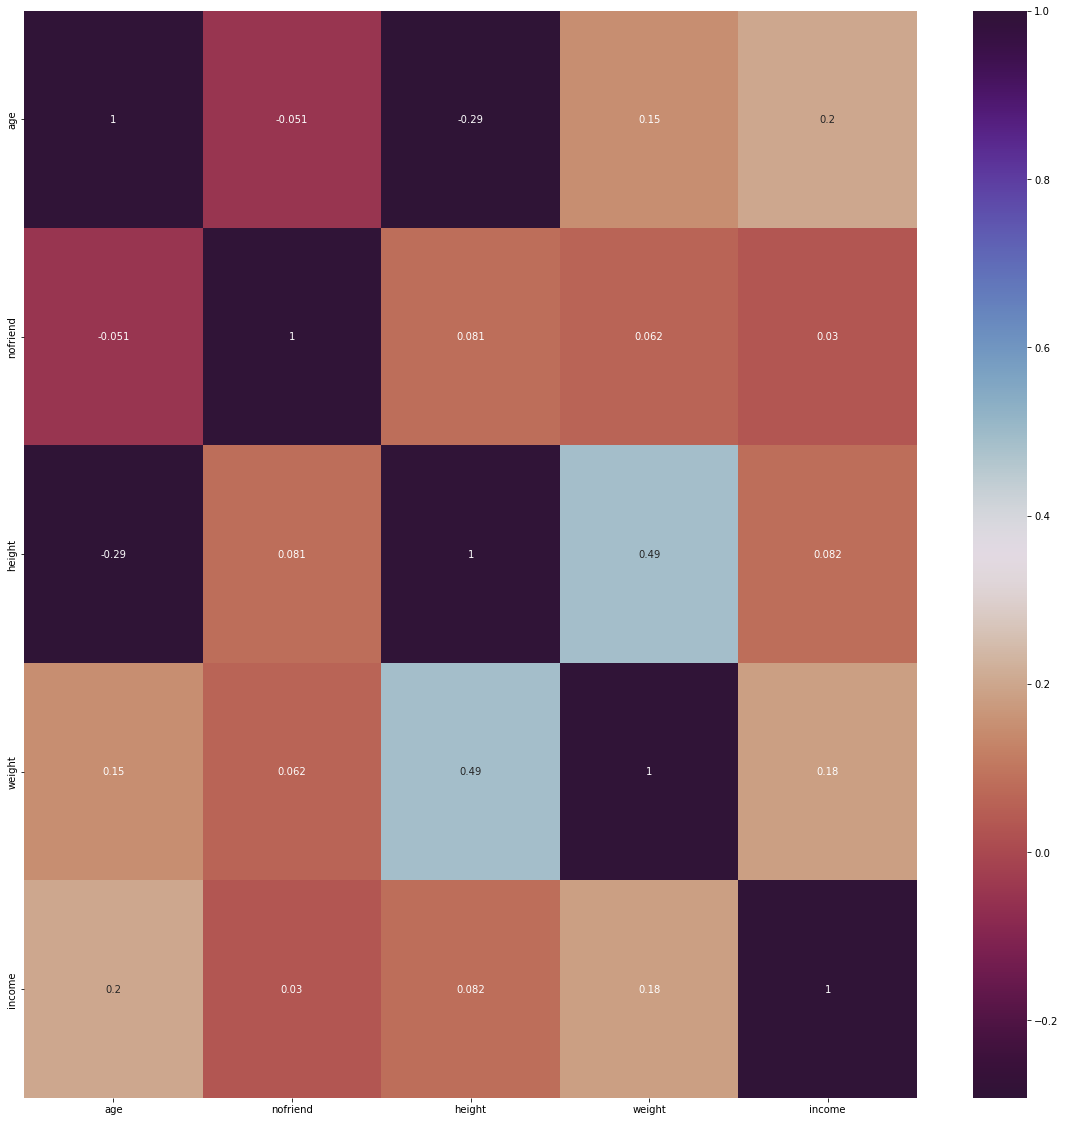

In [7]:
# test correlation between variables
import seaborn as sns
#get correlations of each features in dataset
corrmat = original_dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(original_dataset[top_corr_features].corr(),annot=True,cmap="twilight_shifted_r")

In [8]:
import scipy.stats as stats
a=['age','nofriend','height','weight']
for i in a:
    print(i,':',stats.pointbiserialr(original_dataset['income'],original_dataset[i])[0])

age : 0.20170532474668829
nofriend : 0.030468743268379173
height : 0.08186835817069904
weight : 0.18244712682924336


In [4]:
# generate random integer values
#from random import seed
from random import randint
# seed random number generator
#seed(1)
random_100 = []
random_1000 = []
# generate some integers
for _ in range(10):
    random_1000.append(randint(0, 999))
    random_100.append(randint(0, 99))
print(random_100)
print(random_1000)

[9, 18, 65, 98, 34, 65, 99, 19, 6, 45]
[663, 676, 748, 871, 344, 878, 757, 131, 967, 819]


In [5]:
def cross_tab(df, obs1=[]):
    observed=pd.crosstab(obs1,df['income'])
    val=stats.chi2_contingency(observed)
    return(val[1])

In [6]:
#prepare dataset and which feaures to use for classfication
def prepare_data(df, use_global_feature:bool, is_synhtetic:bool):
    df_new=df.dropna(axis=0)
    #print(df_new.head())
    #print('Dimensions:',df_new.shape)
    col=df_new.columns
    data_type=df_new.dtypes
    uniq=df_new.nunique()
    
    if(is_synhtetic == True):
        df_new['income_cat'] =pd.cut(df_new.income, bins=[0,0.1, 1000,2000,3000,4000, 20000],labels=['No Income','<=1K','>1K & <=2K','>2K & <=3K', '>3K & <=4K', '>4K'], include_lowest=True)
        df_new.drop('income', axis=1, inplace=True)
        df_new.rename(columns = {'income_cat':'income'}, inplace = True)

    #print("\n%30s  %10s   %10s\n " % ("Column Name", "Data Type", "Unique Values"))
    #for i in range(len(df_new.columns)):
        #print("%30s  %10s   %10s " % (col[i],data_type[i],uniq[i]))

    #print("\nDimensions:",df_new.shape[0],'rows and ',df_new.shape[1],'columns')
    df_new['income'].replace({'No Income':0,'<=1K':1,'>1K & <=2K':2,'>2K & <=3K':3,'>3K & <=4K':4, '>4K':5},inplace=True)
    
    
    categorical_cols = df_new.columns[df_new.dtypes==object].tolist()
    categorical_cols
    
    #pd.crosstab(df.relationship,df_new['income'])
    
    df_new_1=pd.get_dummies(df_new,columns=categorical_cols)
    df_new_1.head()
    
    from sklearn.preprocessing import MinMaxScaler
    columns_to_scale = ['age','nofriend','height','weight']
    mms = MinMaxScaler()
    min_max_scaled_columns = mms.fit_transform(df_new_1[columns_to_scale])
    #processed_data = np.concatenate([min_max_scaled_columns, adult_new], axis=1)
    df_new_1['age'],df_new_1['nofriend'],df_new_1['height'],df_new_1['weight']=min_max_scaled_columns[:,0],min_max_scaled_columns[:,1],min_max_scaled_columns[:,2],min_max_scaled_columns[:,3]
    df_new_1.head()
    
    
    if(use_global_feature == False):
        category=df_new_1.columns[df_new_1.dtypes!=object].tolist()[5:]
        #category
        alpha=0.01
        #df=adult_new.drop('income',axis=1)
        count=0
        for i in category:
            p_value=cross_tab(df_new, df_new_1[i])
            if p_value<=alpha:
                count+=1
                features.append(i)
                #print(i,' has a relation')
                #print('p-value for ',i,' is ',cross_tab(adult_new[i]),'\n')
        #print('Number of contributing attributes:',count,'\n')
        #print(features)

        features.append('age')
        features.append('nofriend')
        features.append('height')
        features.append('weight')
        features.append('income')
  
    
    chi2=df_new_1[features]
    return chi2

In [7]:
#split dataset into train and testset
def train_print(clf,x_test,y_test):
    predictions = clf.predict(x_test)
    print('Precision report:\nprecision \t\t\t recall \t\t\t f-score \t\t\t support\n',
          precision_recall_fscore_support(y_test, predictions)[0],'\t',
          precision_recall_fscore_support(y_test, predictions)[1],
          '\t',precision_recall_fscore_support(y_test, predictions)[2],'\t',
          precision_recall_fscore_support(y_test, predictions)[3],'\n')
    print('Confusion matrix:\n',confusion_matrix(y_test, predictions),'\n')
    print('Accuracy score:',accuracy_score(y_test, predictions)*100,'\n')

In [9]:
# Test Accuracy of original dataset
from sklearn.linear_model import LogisticRegression

features=[]

chi2 = prepare_data(original_dataset, False, False)
#test_set=prepare_data(original_dataset, True)
x = chi2.drop('income', axis=1)
y = chi2['income']
#x_train = chi2.drop('income', axis=1)
#y_train = chi2['income']
#x_test = test_set.drop('income', axis=1)
#y_test = test_set['income']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
#X_train, Y_train = SMOTE().fit_resample(x_train, y_train)

logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)

train_print(logmodel,x_test,y_test)
    
predictions = logmodel.predict(x_test)
accuracy_score(y_test, predictions)*100


Precision report:
precision 			 recall 			 f-score 			 support
 [0.53846154 0.43093923 0.45833333 0.3        0.         0.        ] 	 [0.53068592 0.3362069  0.6637931  0.13953488 0.         0.        ] 	 [0.53454545 0.37772397 0.54225352 0.19047619 0.         0.        ] 	 [277 232 348  86  33  24] 

Confusion matrix:
 [[147  47  73  10   0   0]
 [ 42  78 112   0   0   0]
 [ 56  52 231   9   0   0]
 [ 15   2  57  12   0   0]
 [  7   1  21   3   0   1]
 [  6   1  10   6   1   0]] 

Accuracy score: 46.800000000000004 



46.800000000000004

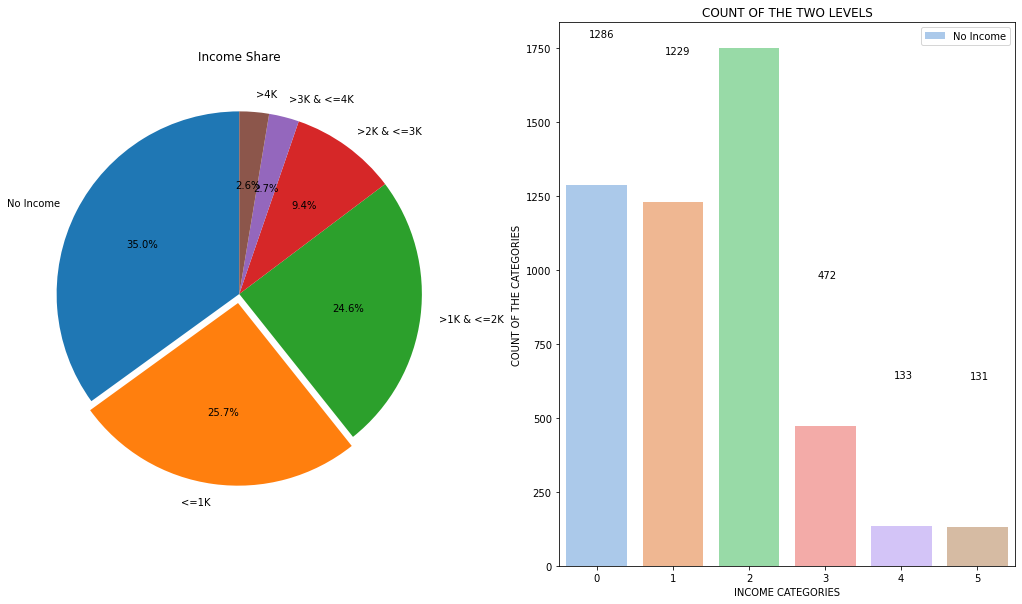

In [16]:
# Exploratory Analysis on different variables
f,ax=plt.subplots(1,2,figsize=(18,10))
#plt.figure(figsize=(7,10))
income1=original_dataset['income'].value_counts()
ax[0].pie(income1,explode=(0,0.05,0,0,0,0),autopct='%1.1f%%',startangle=90,labels=['No Income','<=1K','>1K & <=2K','>2K & <=3K','>3K & <=4K', '>4K'])
ax[0].set_title('Income Share')
ax[1]=sns.countplot(x='income',data=original_dataset,palette='pastel')
ax[1].legend(labels=['No Income','<=1K','>1K & <=2K','>2K & <=3K','>3K & <=4K', '>4K'])
ax[1].set(xlabel="INCOME CATEGORIES")
ax[1].set(ylabel='COUNT OF THE CATEGORIES')
ax[1].set_title('COUNT OF THE TWO LEVELS')

for p in ax[1].patches:
    ax[1].annotate(p.get_height(),(p.get_x()+0.3,p.get_height()+500))

In [10]:
# Train models and test accuracy
accuracy_list=[]
accuracy_list_only_synthetic = []
accuracy_list_original= []

logmodel = np.empty((len(sds_results_list), len(random_1000)), object)
logmodel_original = np.empty(17, object)

sds_results_df = pd.DataFrame(index = [[i.split('.')[0] for i in sds_results_list]], columns=['average accuracy(trS-teO)', 'average accuracy(trS-teS)', 'accuracy original'])

#-------------------------------Train and Test on Original dataset----------------------------------------#

features.clear()
chi2_original = prepare_data(original_dataset, False, False)

x_original = chi2_original.drop('income', axis=1)
y_original = chi2_original['income']

for i in range(17):
    x_train_original, x_test_original, y_train_original, y_test_original = \
                train_test_split(x_original, y_original, test_size=0.20, random_state=np.random , shuffle =True)
    #X_train_original, Y_train_original = SMOTE().fit_resample(x_train_original, y_train_original)

    logmodel_original[i] = LogisticRegression()
    logmodel_original[i].fit(x_train_original, y_train_original)

    #train_print(logmodel,x_test,y_test)

    predictions_original = logmodel_original[i].predict(x_test_original)
    accuracy_list_original.append(accuracy_score(y_test_original, predictions_original)*100)
    sds_results_df.at[sds_results_list[i].split('.')[0], 'accuracy original'] = accuracy_score(y_test_original, predictions_original)*100
print(accuracy_list_original)

#---------------------------------------------------End----------------------------------------------------#
row = -1
for method in sds_results_list:
    df=[]
    row += 1
    accuracy_list.clear()
    accuracy_list_only_synthetic.clear()
    print('Starting file '+ method)
    with open('../Polish_SDS/pickle/'+ method, 'rb') as input_file:
        df = pickle.load(input_file)
    random_index = random_1000
    if(len(df) == 100):
        random_index = random_100
    
    col = -1
    for i in random_index:
        #features.clear()
        col += 1
        chi2 = prepare_data(df[i], True, True)
        test_set=prepare_data(original_dataset, True, False)
        
#-------------------------Train on Synthetic and Test on Original----------------------------------------#
        #x = chi2.drop('income', axis=1)
        #y = chi2['income']
        x_train = chi2.drop('income', axis=1)
        y_train = chi2['income']
        x_test = test_set.drop('income', axis=1)
        y_test = test_set['income']
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
        #X_train, Y_train = SMOTE().fit_resample(x_train, y_train)

        logmodel[row][col] = LogisticRegression()
        logmodel[row][col].fit(x_train, y_train)

        #train_print(logmodel,x_test,y_test)

        predictions = logmodel[row][col].predict(x_test)
        accuracy_list.append(accuracy_score(y_test, predictions)*100)
#---------------------------------------------------End----------------------------------------------------#
        
#-------------------------------Train and Test on Synthetic dataset----------------------------------------#
        x_only_synthetic = chi2.drop('income', axis=1)
        y_only_synthetic = chi2['income']
        x_train_only_synthetic, x_test_only_synthetic, y_train_only_synthetic,\
                    y_test_only_synthetic = train_test_split(x_only_synthetic, y_only_synthetic, \
                    test_size=0.20, random_state=1)
        #X_train_only_synthetic, Y_train_only_synthetic = SMOTE().fit_resample(x_train_only_synthetic, y_train_only_synthetic)
        
        logmodel_only_synthetic = LogisticRegression()
        logmodel_only_synthetic.fit(x_train_only_synthetic, y_train_only_synthetic)

        #train_print(logmodel,x_test,y_test)

        predictions_only_synthetic = logmodel_only_synthetic.predict(x_test_only_synthetic)
        accuracy_list_only_synthetic.append(accuracy_score(y_test_only_synthetic, predictions_only_synthetic)*100)
#---------------------------------------------------End----------------------------------------------------#    
    print('trs-teO ', accuracy_list)
    print('trS-teS ',accuracy_list_only_synthetic)
    sds_results_df.at[method.split('.')[0], 'average accuracy(trS-teO)'] = mean(accuracy_list)
    sds_results_df.at[method.split('.')[0], 'average accuracy(trS-teS)'] = mean(accuracy_list_only_synthetic)
    
    # Write results to CSV
    #with open('../Test_Results/Polish_individual_classification_accuracy.csv', 'a+', newline='') as f: 
        #write = csv.writer(f) 
        #write.writerow([method.split('.')[0], 'trS-teO', accuracy_list, 'trS-teS', accuracy_list_only_synthetic]) 
        #write.writerow(accuracy_list) 
        #new_list.append([method.split('.')[0], accuracy_list])
    #print(method.split('.')[0] + ' = ', sds_results[method.split('.')[0]])
        #print(new_list)
print(sds_results_df)

[46.7, 47.699999999999996, 46.0, 43.9, 44.2, 48.3, 43.8, 45.0, 44.9, 47.0, 45.800000000000004, 44.3, 47.599999999999994, 46.0, 43.6, 46.1, 45.1]
Starting file sdsPolishCatMC.pkl
trs-teO  [46.379999999999995, 46.7, 45.78, 46.839999999999996, 46.36, 46.12, 46.5, 46.839999999999996, 46.36, 46.72]
trS-teS  [47.099999999999994, 44.6, 47.0, 48.0, 47.699999999999996, 44.7, 45.9, 46.400000000000006, 45.5, 46.7]
Starting file sdsPolishCatMCT.pkl
trs-teO  [46.14, 46.379999999999995, 45.660000000000004, 46.48, 46.6, 45.98, 46.26, 46.6, 46.1, 46.379999999999995]
trS-teS  [43.8, 47.4, 46.0, 43.9, 49.9, 47.699999999999996, 46.300000000000004, 46.400000000000006, 44.0, 48.699999999999996]
Starting file sdsPolishCatMP.pkl
trs-teO  [46.7, 46.04, 46.400000000000006, 46.62, 46.339999999999996, 46.02, 45.76, 46.46, 45.92, 45.94]
trS-teS  [43.4, 45.6, 43.7, 43.1, 46.1, 45.0, 42.6, 42.4, 44.6, 44.0]
Starting file sdsPolishCatMPT.pkl
trs-teO  [45.08, 42.980000000000004, 43.96, 40.92, 42.74, 41.83999999999999

In [18]:
mean(accuracy_list_original)

46.476470588235294

In [11]:
column_names = ['Original']
column_names.extend(sds_results_list)
column_names = [s.replace(".pkl", "") for s in column_names]
df_wrong_classfication = pd.DataFrame(index = [[i for i in range(1, (len(random_1000)+1))]], columns = column_names)
df_wrong_classfication

,Original,sdsPolishCatMC,sdsPolishCatMCT,sdsPolishCatMP,sdsPolishCatMPT,sdsPolishDecM,sdsPolishDecMO,sdsPolishDecMOT,sdsPolishDecMT,sdsPolishDecMV,sdsPolishDecMVT,sdsPolishParM,sdsPolishParMO,sdsPolishParMOT,sdsPolishParMT,sdsPolishParMV,sdsPolishParMVT,sdsPolishSamp
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# check which records are incorrectly classified by original model
wrong_list = []
x = x_test_original
y = y_test_original

for i in range(0, 10):
    wrong_list.clear()
    pre = logmodel_original[i].predict(x)
    for row_index, (input, prediction, label) in enumerate(zip (x, pre, y)):
        if prediction != label:
            wrong_list.append(row_index)
            #print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
    print(wrong_list)
    df_wrong_classfication.iat[i, df_wrong_classfication.columns.get_loc('Original')] = wrong_list 

[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]


In [13]:
# check which records are incorrectly classified by synthetic model
wrong_list = []

x = x_test_original
y = y_test_original
for i in range(0, len(logmodel)):
    print(sds_results_list[i].split('.')[0])
    for j in range(0, len(logmodel[i])):
        wrong_list.clear()
        pre = logmodel[i][j].predict(x)
        for row_index, (input, prediction, label) in enumerate(zip (x, pre, y)):
            if prediction != label:
                wrong_list.append(row_index)
                #print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
        print(wrong_list)
        df_wrong_classfication.iat[j, df_wrong_classfication.columns.get_loc(sds_results_list[i].split('.')[0])] = wrong_list

sdsPolishCatMC
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 18, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 24, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 18, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 18, 20, 22, 23, 25, 26, 27]
sdsPolishCatMCT
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 17, 18, 20, 21, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 18, 20, 22, 23, 25, 26, 27]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 25, 26, 27]
[1, 2, 4, 5, 6, 8, 9, 11,

[4, 6, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 4, 6, 8, 9, 11, 12, 17, 20, 21, 22, 23, 24, 25, 26, 27]
sdsPolishParMVT
[1, 4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 2, 4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 27]
[1, 4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 4, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27]
[4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27]
[4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 27]
[1, 4, 6, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 27]
[1, 4, 8, 9, 11, 12, 17, 20, 21, 22, 23, 24, 25, 27]
[1, 4, 6, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 27]
[4, 6, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 27]
sdsPolishSamp
[0, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 27]
[0, 4, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 27]
[0, 3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 17, 19, 20, 21